In [175]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        if line:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, color=[255, 0, 0], thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = get_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    lines = calculate_line_extrapolations(lines, img)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color, thickness)
    return line_img

def get_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns the houghlines for the given image.
    
    Args:
        img: The array like image or PIL image
        rho: The rho parameter for the hough lines
        theta: The theta parameter for the hough lines
        min_line_len: The minimum lenght of the line
        max_line_gap: The maximum gap between two lines.
    Returns:
        lines: an array including the lines found.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def calculate_line_extrapolations(lines, image):
    """
    Calclates the extrapolation for the given lines with very simple rule.
    
    For gaining the function of extrapolation the polyfit is used.
    It is also checked that x1, x2 that are calculated through the extrapolation are
    indeed in the image. Otherwise the image was not usable and no lines are returned.
    
    Args:
        lines: The list of hough lines to be extrapolated in single line
        image: The array like Image or PIL image
        
    Returns:
        lines
    """
    imshape = image.shape;
    middle_points_x = []
    middle_points_y = []
    for line in lines:
        x, y = calculate_middle_point(line)
        middle_points_x.append(x)
        middle_points_y.append(y)
    if len(middle_points_x) > 0 and len(middle_points_y) > 0:
        m, b = np.polyfit(middle_points_x, middle_points_y, 1)
        y1 = imshape[0]
        y2 = imshape[0]/2 +45 
        x1 = (y1 - b)/m
        x2 = (y2 - b)/m
        line = [int(x1), int(y1), int(x2), int(y2)]
        if x1 <= imshape[1] and x1 >= 0 and x2 <=imshape[1] and x2>=0:
            lines = [[line]]
            return lines
    return [False]

def calculate_middle_point(line):
    """
    Calculates the middle point of the given line.
    
    Args:
        line: The array that contains the lines x1,x2,y1,y2
        
    Returns: 
        m: The middle point of the given line
    """
    for x1,y1,x2,y2 in line:
        xM = (x1 + x2)/2
        yM = (y1 + y2)/2
        return [xM, yM]

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def read_img(path):
    """
    Reads the given image to project
    
    Args:
        path: The string path to the given file to be read.
        
    Returns:
        Array like or PIL image
    """
    image = mpimg.imread(path)
    return image

def get_left_region_of_interest(image):
    """
    Returns the left region of interest for the given image.
    Create a region in middle left of the given image.
    
    Args:
        image: The image array or PIL image
        
    Returns:
        vertices: The points that contain the vertics.
    """
    imshape = image.shape
    left_point =  (imshape[1]/8, imshape[0])
    right_point = (imshape[1]/2, imshape[0])
    apex1 = (imshape[1]/2 - 20, imshape[0]/2 +25)
    apex2 = (imshape[1]/2 + 20, imshape[0]/2 +25)
    vertices = np.array([[left_point, apex1, apex2, right_point]], dtype=np.int32)
    return vertices

def get_right_region_of_interest(image):
    """
    Returns the left region of interest for the given image.
    Creates a region in miffle right of the given image.
    
    Args:
        image: The image array or PIL image
        
    Returns:
        vertices: The points that contain the vertics.
    """
    imshape = image.shape
    right_point =  (imshape[1],imshape[0])
    left_point = (imshape[1]/2,imshape[0])
    apex1 = (imshape[1]/2 -20, imshape[0]/2 +25)
    apex2 = (imshape[1]/2 + 20, imshape[0]/2 +25)
    vertices = np.array([[left_point, apex1, apex2, right_point]], dtype=np.int32)
    return vertices

def get_vertices(image):
    """
    Calculates the points of interset in the image. it should be Trapezoid when connected.
    
    Args:
        image: The array like image or PIL image
        
    Returns:
        an array of points that can be used to create Trapezoid mesh
    """
    imshape = image.shape
    left_point =  (imshape[1]/8,imshape[0])
    right_point = (imshape[1],imshape[0])
    apex1 = (imshape[1]/2 - 20 , imshape[0]/2 +50)
    apex2 = (imshape[1]/2 + 20, imshape[0]/2 +50)
    vertices = np.array([[left_point, apex1, apex2, right_point]], dtype=np.int32)
    return vertices

In [176]:
def process_image(image):
    """
    Proccess the given image with the find lane line and returns the result image
    
    Args:
        image: The array like image file or PIL image
        
    Returns:
        image
    """
    # parameters:
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    color = [255,0,0]
    thikness = 10
    rho = 1
    theta = np.pi/180
    hough_lines_threshold = 20
    min_line_len = 15
    max_line_gap = 5
    # method
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size)
    edges = canny(blur_gray, low_threshold, high_threshold)
    vertices_left = get_left_region_of_interest(image)
    interest_region_left = region_of_interest(edges, vertices_left)
    line_image_left = draw_hough_lines(
        interest_region_left, 
        rho, 
        theta, 
        hough_lines_threshold, 
        min_line_len, 
        max_line_gap, 
        color, 
        thikness)
    cv2.imwrite("images/line_image_left_2.jpeg", line_image_left)
    vertices_right = get_right_region_of_interest(image)
    interest_region_right = region_of_interest(edges, vertices_right)
    line_image_right = draw_hough_lines(
        interest_region_right, 
        rho, 
        theta, 
        hough_lines_threshold, 
        min_line_len, 
        max_line_gap, 
        color, 
        thikness)
    combo = weighted_img(line_image_left, image, 0.8, 1)
    combo = weighted_img(line_image_right, combo, 0.8, 1)
    return combo


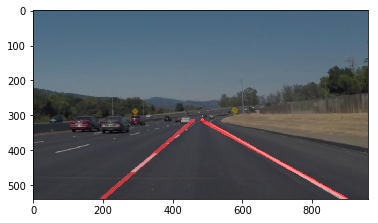

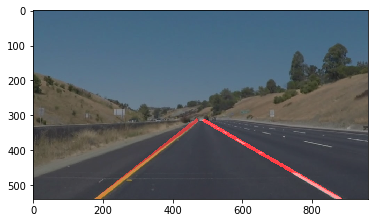

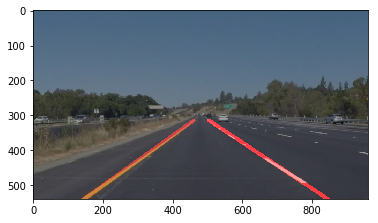

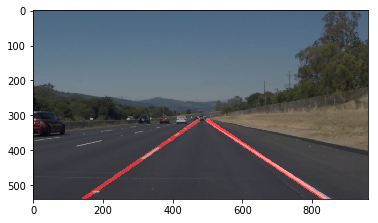

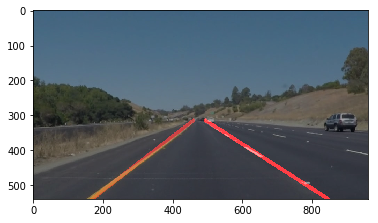

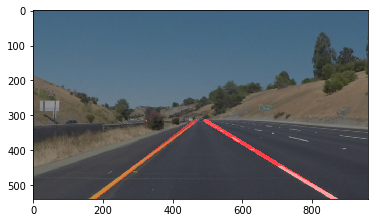

In [177]:
import os
images = os.listdir("test_images/")
for path in images:
    image = read_img("test_images/"+path)
    combo = process_image(image)
    plt.figure()
    plt.imshow(combo)
    plt.show()

In [142]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4








  0%|          | 0/682 [00:00<?, ?it/s]





  1%|          | 5/682 [00:00<00:14, 46.49it/s]





  2%|▏         | 11/682 [00:00<00:13, 48.06it/s]





  3%|▎         | 18/682 [00:00<00:12, 51.40it/s]





  4%|▎         | 24/682 [00:00<00:12, 53.24it/s]





  5%|▍         | 31/682 [00:00<00:11, 55.56it/s]





  5%|▌         | 37/682 [00:00<00:11, 56.58it/s]





  6%|▋         | 43/682 [00:00<00:11, 54.78it/s]





  7%|▋         | 49/682 [00:00<00:14, 44.84it/s]





  8%|▊         | 54/682 [00:01<00:15, 40.49it/s]





  9%|▊         | 59/682 [00:01<00:15, 41.28it/s]





  9%|▉         | 64/682 [00:01<00:25, 24.64it/s]





 10%|▉         | 68/682 [00:01<00:24, 24.79it/s]





 11%|█         | 72/682 [00:01<00:23, 26.43it/s]





 11%|█▏        | 77/682 [00:02<00:19, 30.31it/s]





 12%|█▏        | 81/682 [00:02<00:27, 22.15it/s]





 13%|█▎        | 87/682 [00:02<00:22, 26.19it/s]





 13%|█▎        | 91/682 [00:02<00:22, 25.94it/s]





 14%|█▍        | 95/682 [00:02<0

 65%|██████▍   | 442/682 [00:17<00:12, 19.78it/s]





 65%|██████▌   | 445/682 [00:17<00:11, 20.95it/s]





 66%|██████▌   | 450/682 [00:18<00:09, 24.11it/s]





 66%|██████▋   | 453/682 [00:18<00:12, 18.55it/s]





 67%|██████▋   | 458/682 [00:18<00:10, 22.09it/s]





 68%|██████▊   | 461/682 [00:18<00:09, 22.64it/s]





 68%|██████▊   | 466/682 [00:18<00:08, 24.88it/s]





 69%|██████▉   | 469/682 [00:18<00:09, 22.64it/s]





 69%|██████▉   | 472/682 [00:18<00:08, 24.28it/s]





 70%|██████▉   | 475/682 [00:19<00:10, 20.26it/s]





 70%|███████   | 480/682 [00:19<00:08, 24.29it/s]





 71%|███████   | 485/682 [00:19<00:07, 25.86it/s]





 72%|███████▏  | 489/682 [00:19<00:08, 22.43it/s]





 72%|███████▏  | 492/682 [00:19<00:08, 23.57it/s]





 73%|███████▎  | 495/682 [00:19<00:07, 24.77it/s]





 73%|███████▎  | 498/682 [00:20<00:08, 21.71it/s]





 74%|███████▎  | 502/682 [00:20<00:07, 24.20it/s]





 74%|███████▍  | 505/682 [00:20<00:09, 18.27it/s]





 75%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 43s, sys: 11.6 s, total: 2min 54s
Wall time: 28.5 s
